# Day-Ahead Power Peak Prediction PoC

## Introduction

This notebook presents a proof-of-concept (PoC) for predicting power peaks using an hourly energy dataset merged with temperature data. Our approach is inspired by the framework proposed in Xia et al. (2024), which focuses on accurately forecasting peak loads at the individual household level. In our case, we adapt the method for an aggregated application (e.g., for malls) by leveraging hourly data.

### Key Components

1. **Data Aggregation and Preprocessing**  
   - **Aggregation:** We start by aggregating minute-level energy data to an hourly resolution to match the hourly temperature data.
   - **Normalization:** Daily load profiles are created and normalized to facilitate pattern extraction and comparison across different days.


2. **Time Interval Extraction**  
   - The average daily load profile is analyzed to detect local peaks and valleys.
   - These peaks and valleys help segment the day into meaningful time intervals (such as morning, afternoon, and evening) where distinct peak load patterns occur.

3. **Load Decomposition**  
   - **First Stage:** The total daily load is decomposed into:
     - **Base Load:** The stable, underlying consumption.
     - **Peak Load:** The extra consumption above a defined threshold.
   - **Second Stage:** The peak load is further broken down into:
     - **Magnitude:** How high the extra consumption is.
     - **Timing:** When during the day the peak occurs.

4. **Forecasting and Model Comparison**  
   - **Baseline:** We compare a direct forecasting approach (predicting the full daily load without decomposition) as a baseline.
   - **Decomposition-Based Approach:** We then forecast the base load and separately predict the peak load’s magnitude and timing.
   - **Method Comparison:** Additionally, we compare deterministic models (e.g., Gaussian Process Regression, Random Forest, Gradient Boosting) against their probabilistic counterparts (e.g., quantile regression versions) to evaluate how well they capture both the magnitude and the timing of the peaks.


### Rationale

- **Addressing Volatility:**  
  Traditional time series models (like ARIMA) often struggle with the volatile nature of individual load curves and the "double penalty" problem—where errors in both the magnitude and timing of peaks lead to compounding inaccuracies. Besides such models has a tendency to elvel out the complexe patterns found in hourly and minute domain, making them not suitable for our context.
  
- **Decomposition Benefits:**  
  By decomposing the load into base and peak components and further breaking the peak load into its magnitude and timing, the approach allows us to tackle the unpredictable nature of peak events more effectively.
  
- **Machine Learning Focus:**  
  The framework from the paper primarily employs machine learning methods (such as Gaussian Process Regression, Random Forest, and Gradient Boosting) which have shown superior performance in capturing non-linear relationships and uncertainty in peak loads compared to classical statistical models.

This notebook outlines the steps from data loading and preprocessing through to feature engineering, model training, and evaluation—demonstrating why the decomposition-based approach, along with a comparison between deterministic and probabilistic methods, provides a more robust solution for power peak prediction than a direct forecasting approach.

---


## Import Libraries and Load Dataset

In this cell, we import the necessary Python libraries and load the combined energy and temperature dataset from "energy_and_temperature_minute_data.csv." We then convert the timestamp column to datetime.


In [46]:
# Cell 1: Import necessary libraries and load the dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks

%matplotlib inline

# Load the combined dataset (energy demand + temperature)
data_file = "energy_and_temperature_minute_data.csv"
df = pd.read_csv(data_file, sep=";", low_memory=False)

# Convert the timestamp column to datetime (assuming the column is named 'timestamp_utc')
df["timestamp_utc"] = pd.to_datetime(df["timestamp_utc"], utc=True, errors="coerce")

# Inspect the first few rows and column names
print("Columns in dataset:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())
print(df.info())

Columns in dataset:
['timestamp_utc', 'active_power_W', 'active_power_neg_W', 'reactive_power_VAr', 'reactive_power_neg_VAr', 'phase1_current_A', 'phase2_current_A', 'phase3_current_A', 'phase1_voltage_V', 'phase2_voltage_V', 'phase3_voltage_V', 'meter_id', 'air_temperature']

First few rows:
                     timestamp_utc  active_power_W  active_power_neg_W  \
0 2025-02-07 13:33:31.488000+00:00             802                   0   
1 2025-02-07 13:33:41.628000+00:00             809                   0   
2 2025-02-07 13:33:51.571000+00:00             808                   0   
3 2025-02-07 13:34:01.563000+00:00             826                   0   
4 2025-02-07 13:34:11.498000+00:00             852                   0   

   reactive_power_VAr  reactive_power_neg_VAr  phase1_current_A  \
0                  16                       0             12640   
1                  16                       0             12670   
2                  15                       0             12

## Filter Complete Days and Aggregate to Hourly Data

In this cell, we first extract the date from our minute-level timestamps and count the number of records per sensor per day. A full day is defined as having 1440 records (i.e., one reading per minute for 24 hours). We then filter the dataset to keep only those days with complete data. Finally, we aggregate the filtered data to an hourly resolution and report how many days were missing per sensor.


In [74]:

# Ensure the timestamp is in datetime format and extract date
df["date"] = df["timestamp_utc"].dt.date

# Count records per sensor per day
records_per_day = df.groupby(["meter_id", "date"]).size().reset_index(name="count")

# Define 80% of full day
threshold  = 1152

# Identify complete days (those with exactly 1440 records)
complete_days = records_per_day[records_per_day["count"] >= threshold]

print("Number of complete days found per sensor:")
print(complete_days.groupby("meter_id")["date"].count())

# Create a set of complete (meter_id, date) pairs
complete_set = set(zip(complete_days["meter_id"], complete_days["date"]))

# Filter the original dataframe to include only rows from complete days
df_complete = df[df.apply(lambda row: (row["meter_id"], row["date"]) in complete_set, axis=1)]
print("\nOriginal dataset shape:", df.shape)
print("Filtered dataset shape (complete days only):", df_complete.shape)

# Count missing days per sensor:
original_days = df.groupby("meter_id")["date"].nunique().reset_index(name="original_days")
filtered_days = df_complete.groupby("meter_id")["date"].nunique().reset_index(name="complete_days")
missing_days = pd.merge(original_days, filtered_days, on="meter_id", how="left")
missing_days["missing_days"] = missing_days["original_days"] - missing_days["complete_days"]
print("\nMissing days per sensor:")
print(missing_days)

# Aggregate the complete data to hourly data
df_complete["timestamp_hour"] = df_complete["timestamp_utc"].dt.floor("H")
hourly_df = df_complete.groupby(["timestamp_hour", "meter_id"]).agg({
    "active_power_W": "mean",      
    "active_power_neg_W": "mean",
    "reactive_power_VAr": "mean",
    "reactive_power_neg_VAr": "mean",
    "phase1_current_A": "mean",
    "phase2_current_A": "mean",
    "phase3_current_A": "mean",
    "phase1_voltage_V": "mean",
    "phase2_voltage_V": "mean",
    "phase3_voltage_V": "mean",
    "air_temperature": "mean"
}).reset_index()

# Rename the aggregated timestamp back to timestamp_utc if desired
hourly_df.rename(columns={"timestamp_hour": "timestamp_utc"}, inplace=True)
print("\nHourly aggregated data:")
print(hourly_df.head())


Number of complete days found per sensor:
meter_id
6kPJw9QF    35
Jfmwhk2e    18
KGdRbnJc    35
Name: date, dtype: int64

Original dataset shape: (126528, 15)
Filtered dataset shape (complete days only): (121427, 15)

Missing days per sensor:
   meter_id  original_days  complete_days  missing_days
0  6kPJw9QF             37             35             2
1  Jfmwhk2e             22             18             4
2  KGdRbnJc             37             35             2

Hourly aggregated data:
              timestamp_utc  meter_id  active_power_W  active_power_neg_W  \
0 2025-02-08 00:00:00+00:00  6kPJw9QF      238.186441                 0.0   
1 2025-02-08 00:00:00+00:00  Jfmwhk2e      450.736842                 0.0   
2 2025-02-08 00:00:00+00:00  KGdRbnJc       44.771930                 0.0   
3 2025-02-08 01:00:00+00:00  6kPJw9QF      213.315789                 0.0   
4 2025-02-08 01:00:00+00:00  Jfmwhk2e      463.500000                 0.0   

   reactive_power_VAr  reactive_power_neg_VAr

C:\Users\saidh\AppData\Local\Temp\ipykernel_43688\187453696.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_complete["timestamp_hour"] = df_complete["timestamp_utc"].dt.floor("H")
C:\Users\saidh\AppData\Local\Temp\ipykernel_43688\187453696.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_complete["timestamp_hour"] = df_complete["timestamp_utc"].dt.floor("H")


## Analyze and Visualize Data Frequency for All Sensors

In this cell, we loop over all unique sensors (meter_id) and compute the time differences between consecutive records for each sensor. We then plot histograms of these time differences to verify the data frequency for each sensor.



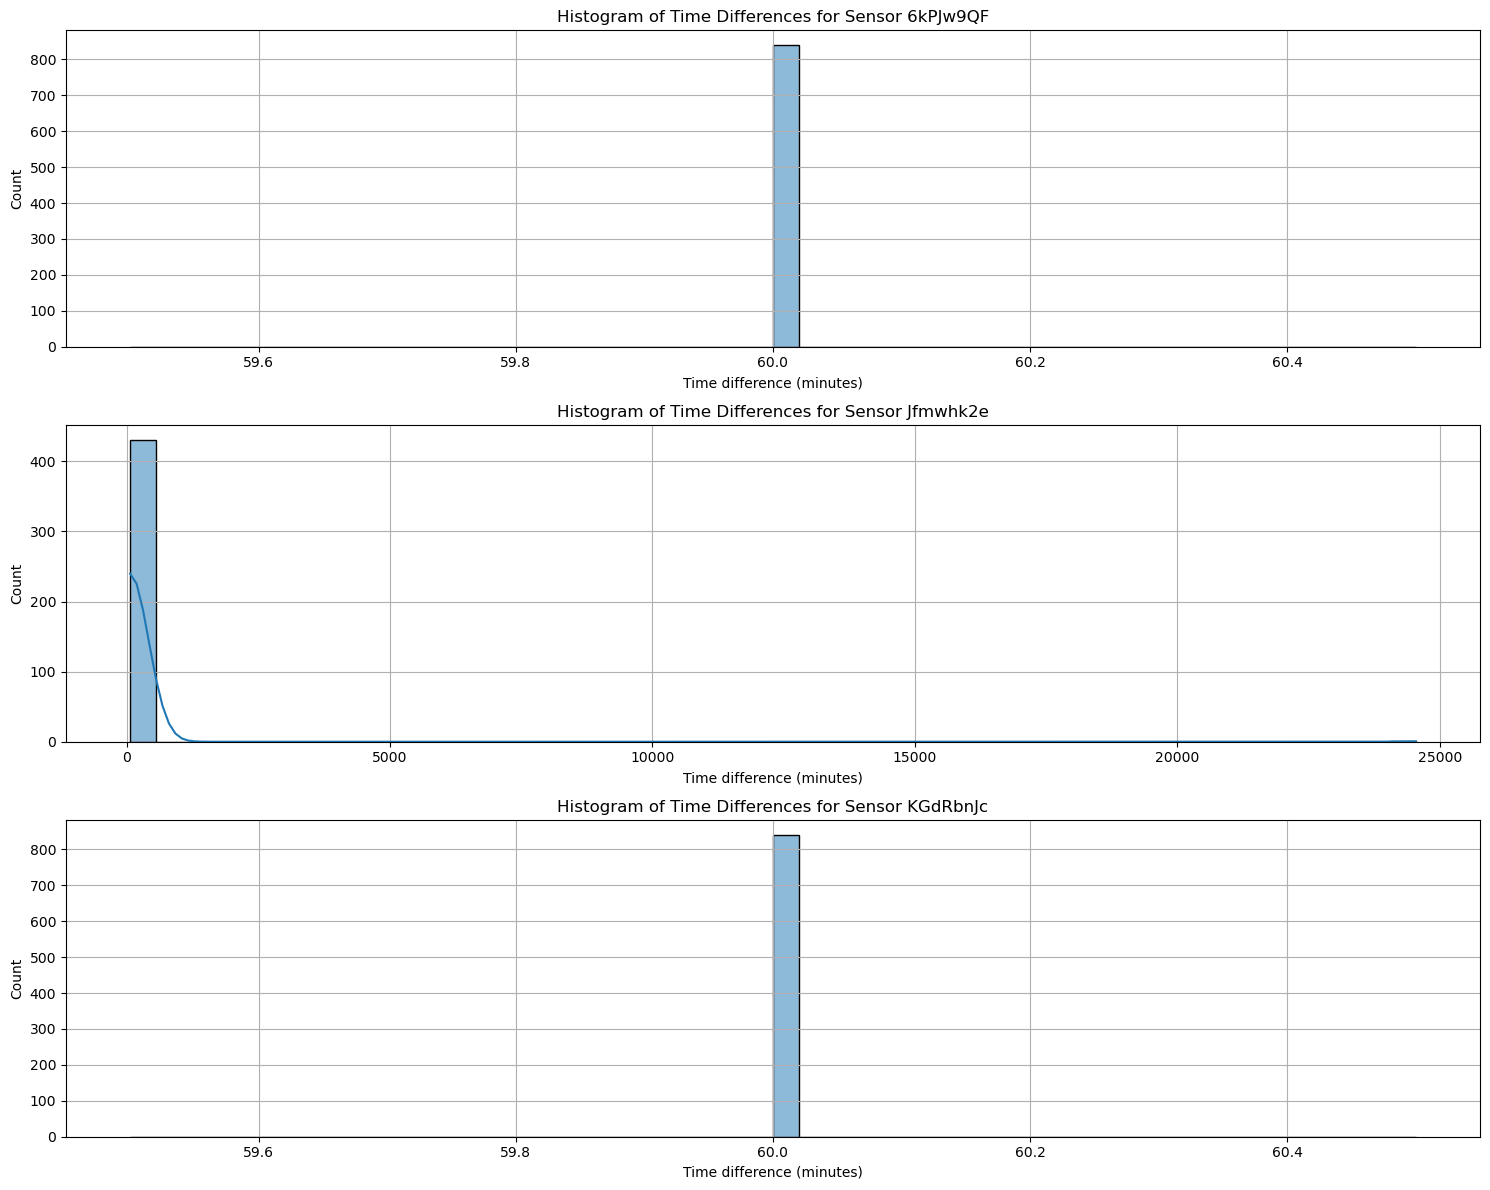

In [75]:

# Get the list of unique sensor IDs
sensor_ids = hourly_df["meter_id"].unique()
n_sensors = len(sensor_ids)

plt.figure(figsize=(15, 4 * n_sensors))

for i, sensor in enumerate(sensor_ids, 1):
    df_filtered_sensor = hourly_df[hourly_df["meter_id"] == sensor].sort_values("timestamp_utc")
    # Compute time differences in minutes between consecutive records
    df_filtered_sensor["time_diff_min"] = df_filtered_sensor["timestamp_utc"].diff().dt.total_seconds() / 60
    
    # Create a subplot for each sensor
    plt.subplot(n_sensors, 1, i)
    sns.histplot(df_filtered_sensor["time_diff_min"].dropna(), bins=50, kde=True)
    plt.xlabel("Time difference (minutes)")
    plt.title(f"Histogram of Time Differences for Sensor {sensor}")
    plt.grid(True)

plt.tight_layout()
plt.show()


## Create Daily Load Profiles

We pivot the hourly data to create daily load profiles for each sensor. Each profile will contain 24 hourly values.


In [76]:
hourly_df["date"] = hourly_df["timestamp_utc"].dt.date

# Pivot to get 24 hourly values per day per sensor (for active power)
daily_profiles = hourly_df.pivot_table(
    index=["date", "meter_id"],
    columns=hourly_df["timestamp_utc"].dt.hour,
    values="active_power_W"
)

# Rename the hourly columns to a consistent format (e.g., hour_0, hour_1, ..., hour_23)
daily_profiles.columns = [f"hour_{col}" for col in daily_profiles.columns]
daily_profiles.reset_index(inplace=True)

print("Sample daily load profiles:")
print(daily_profiles.head())


Sample daily load profiles:
         date  meter_id      hour_0      hour_1      hour_2      hour_3  \
0  2025-02-08  6kPJw9QF  238.186441  213.315789  204.724138  205.875000   
1  2025-02-08  Jfmwhk2e  450.736842  463.500000  450.660714  450.775862   
2  2025-02-08  KGdRbnJc   44.771930   44.879310   45.120690   45.228070   
3  2025-02-09  6kPJw9QF  229.206897  211.724138  207.333333  212.913793   
4  2025-02-09  Jfmwhk2e  460.964912  449.578947  458.210526  479.839286   

       hour_4      hour_5      hour_6      hour_7  ...      hour_14  \
0  207.333333  242.288136  262.551724  318.964912  ...   857.392857   
1  464.339286  527.339286  560.666667  593.859649  ...  1172.696429   
2   43.928571   43.105263   43.578947   43.672414  ...    96.732143   
3  209.741379  206.535714  215.508772  215.345455  ...   279.844828   
4  469.750000  492.245614  484.456140  473.678571  ...   477.965517   

       hour_15      hour_16      hour_17     hour_18     hour_19     hour_20  \
0   882.327273

## Normalize Daily Load Profiles and Display Average Profiles per Sensor

In this cell, we normalize each day's load profile by dividing the 24 hourly values by the day's maximum load. Then, we compute the average normalized daily load profile for each sensor separately and plot them on the same graph for comparison.


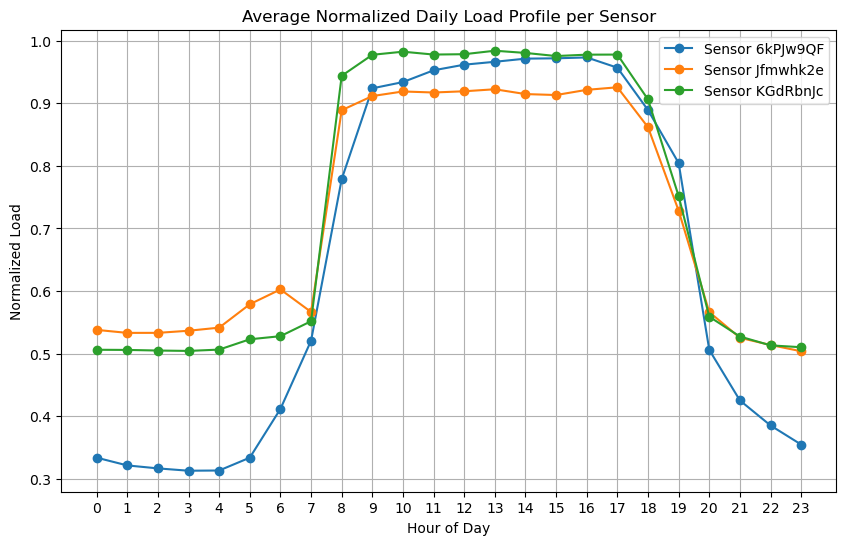

In [ ]:
hourly_cols = [col for col in daily_profiles.columns if col.startswith("hour_")]

def normalize_profile(row):
    vals = row[hourly_cols].values.astype(float)
    max_val = np.max(vals)
    if max_val > 0:
        return vals / max_val
    else:
        return vals

# Apply normalization to each day's load profile
daily_profiles_normalized = daily_profiles.copy()
daily_profiles_normalized[hourly_cols] = daily_profiles_normalized[hourly_cols].apply(normalize_profile, axis=1, result_type="expand")

# Get the unique sensor IDs
sensors = daily_profiles_normalized["meter_id"].unique()

# Plot the average normalized daily load profile for each sensor
plt.figure(figsize=(10, 6))
for sensor in sensors:
    sensor_data = daily_profiles_normalized[daily_profiles_normalized["meter_id"] == sensor]
    avg_profile_sensor = sensor_data[hourly_cols].mean()
    plt.plot(range(24), avg_profile_sensor, marker="o", label=f"Sensor {sensor}")

plt.title("Average Normalized Daily Load Profile per Sensor")
plt.xlabel("Hour of Day")
plt.ylabel("Normalized Load")
plt.xticks(range(24))
plt.legend()
plt.grid(True)
plt.show()


C:\Users\saidh\AppData\Local\Temp\ipykernel_43688\2760446431.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(peaks, avg_profile_sensor[peaks], "x", markersize=10, label="Peaks")
C:\Users\saidh\AppData\Local\Temp\ipykernel_43688\2760446431.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax.plot(valleys, avg_profile_sensor[valleys], "v", markersize=10, label="Valleys")
C:\Users\saidh\AppData\Local\Temp\ipykernel_43688\2760446431.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFram

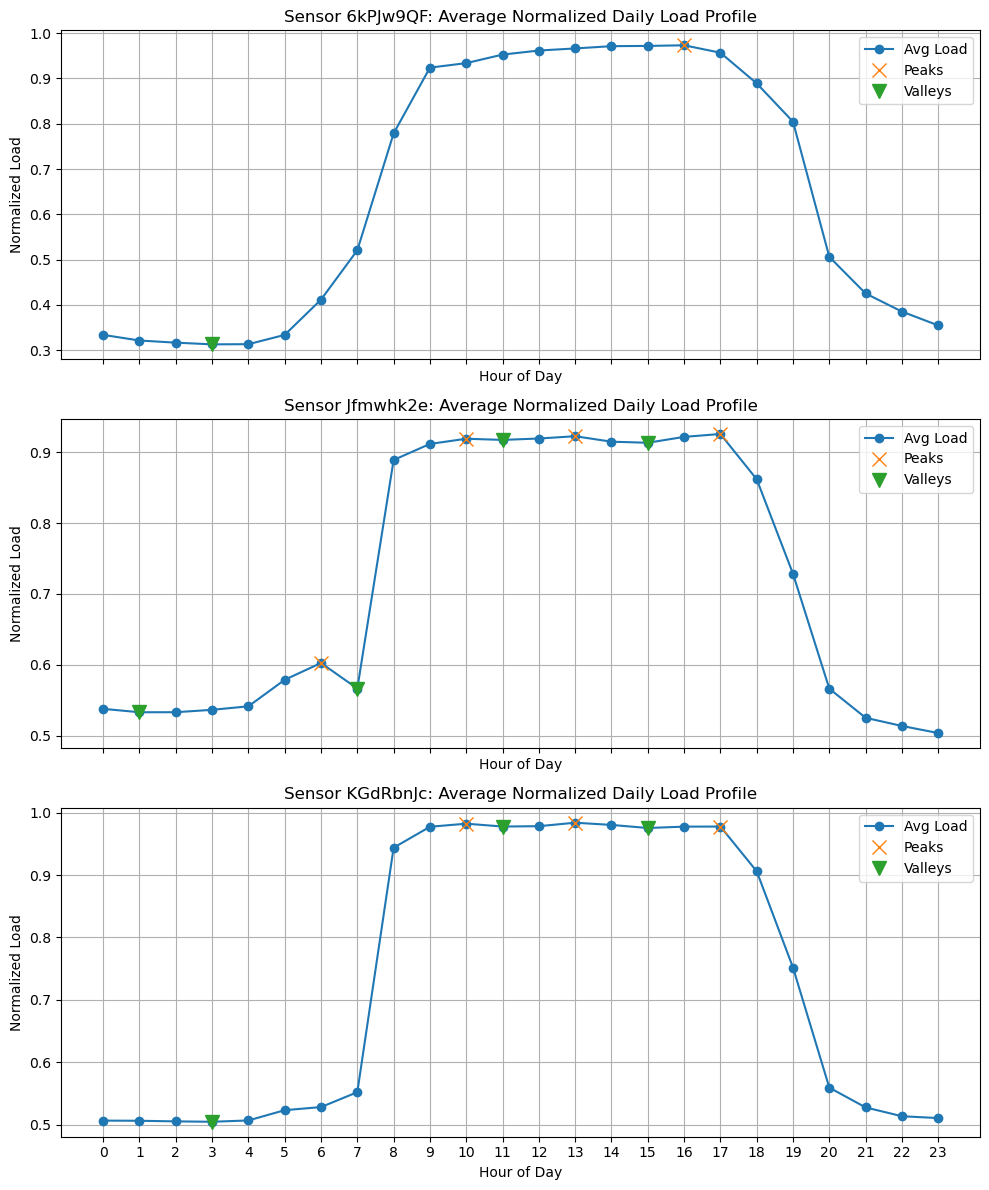

In [81]:
# Cell X+2: Detect peaks and valleys for each sensor's average normalized daily load profile
from scipy.signal import find_peaks

# Get unique sensor IDs from your normalized daily profiles
sensors = daily_profiles_normalized["meter_id"].unique()
n_sensors = len(sensors)

# Create subplots to visualize each sensor separately
fig, axes = plt.subplots(n_sensors, 1, figsize=(10, 4 * n_sensors), sharex=True)

# Loop over each sensor to compute and plot its average profile with detected peaks/valleys
for i, sensor in enumerate(sensors):
    sensor_data = daily_profiles_normalized[daily_profiles_normalized["meter_id"] == sensor]
    # Compute the average normalized daily load profile for the sensor
    avg_profile_sensor = sensor_data[hourly_cols].mean()
    
    # Detect peaks in the average profile
    peaks, _ = find_peaks(avg_profile_sensor, distance=1)
    # Detect valleys (by finding peaks in the inverted profile)
    valleys, _ = find_peaks(-avg_profile_sensor, distance=1)
    
    # Plot on the appropriate subplot
    ax = axes[i] if n_sensors > 1 else axes
    ax.plot(range(24), avg_profile_sensor, marker="o", label="Avg Load")
    ax.plot(peaks, avg_profile_sensor[peaks], "x", markersize=10, label="Peaks")
    ax.plot(valleys, avg_profile_sensor[valleys], "v", markersize=10, label="Valleys")
    ax.set_title(f"Sensor {sensor}: Average Normalized Daily Load Profile")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Normalized Load")
    ax.set_xticks(range(24))
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()


## Decompose Daily Load into Base Load and Peak Load

In this cell, we decompose each sensor's normalized daily load profile into two parts:
- **Base Load:** The portion of the load up to a boundary (here, using the median).
- **Peak Load:** The excess load above that boundary.

We also extract the hour at which the peak (excess) is highest. This mirrors the paper's first-stage decomposition.


In [82]:
def decompose_load(row):
    # Extract the 24 hourly values from the normalized profile
    values = row[hourly_cols].values.astype(float)
    # Define the base-peak boundary as the median of the daily profile
    boundary = np.median(values)
    # Base load: every hour's consumption capped at the boundary
    base_load = np.minimum(values, boundary)
    # Peak load: the extra consumption above the boundary
    peak_load = np.maximum(values - boundary, 0)
    # Return the total base load, total peak load, and the hour when peak load is maximal
    return pd.Series({
        "total_base_load": np.sum(base_load),
        "total_peak_load": np.sum(peak_load),
        "peak_load_hour": np.argmax(peak_load)  # returns an integer 0-23
    })

# Apply decomposition to each daily profile (using the normalized profiles)
decomposition = daily_profiles_normalized.apply(decompose_load, axis=1)
# Merge the decomposition results with the original daily profiles
daily_profiles = pd.concat([daily_profiles, decomposition], axis=1)

print("Sample of daily profiles with decomposition:")
print(daily_profiles.head())


Sample of daily profiles with decomposition:
         date  meter_id      hour_0      hour_1      hour_2      hour_3  \
0  2025-02-08  6kPJw9QF  238.186441  213.315789  204.724138  205.875000   
1  2025-02-08  Jfmwhk2e  450.736842  463.500000  450.660714  450.775862   
2  2025-02-08  KGdRbnJc   44.771930   44.879310   45.120690   45.228070   
3  2025-02-09  6kPJw9QF  229.206897  211.724138  207.333333  212.913793   
4  2025-02-09  Jfmwhk2e  460.964912  449.578947  458.210526  479.839286   

       hour_4      hour_5      hour_6      hour_7  ...      hour_17  \
0  207.333333  242.288136  262.551724  318.964912  ...   745.385965   
1  464.339286  527.339286  560.666667  593.859649  ...  1085.807018   
2   43.928571   43.105263   43.578947   43.672414  ...    97.789474   
3  209.741379  206.535714  215.508772  215.345455  ...   304.894737   
4  469.750000  492.245614  484.456140  473.678571  ...   544.875000   

      hour_18     hour_19     hour_20     hour_21     hour_22     hour_23  \


## Feature Engineering for Peak Load Forecasting

Next, we construct additional features that will help predict peak load characteristics. In this cell we:
- Create lag features (e.g., the previous day’s, two days ago, and one week ago’s total peak load) for each sensor.
- Merge daily average temperature information from the hourly data.


In [ ]:
# Ensure the daily_profiles is sorted by sensor and date
daily_profiles.sort_values(by=["meter_id", "date"], inplace=True)
daily_profiles["date"] = pd.to_datetime(daily_profiles["date"])

# Create lag features for the total peak load
daily_profiles["lag1_peak"] = daily_profiles.groupby("meter_id")["total_peak_load"].shift(1)
daily_profiles["lag2_peak"] = daily_profiles.groupby("meter_id")["total_peak_load"].shift(2)
daily_profiles["lag7_peak"] = daily_profiles.groupby("meter_id")["total_peak_load"].shift(7)

# Build a daily temperature feature from the hourly data: compute daily average temperature
hourly_df["date"] = hourly_df["timestamp_utc"].dt.date
daily_temp = hourly_df.groupby("date")["air_temperature"].mean().reset_index()
daily_temp["date"] = pd.to_datetime(daily_temp["date"])

# Merge the daily temperature with the daily profiles based on date
daily_profiles = pd.merge(daily_profiles, daily_temp, on="date", how="left")

print("Daily profiles with additional features:")
print(daily_profiles.head())


Daily profiles with additional features:
        date  meter_id      hour_0      hour_1      hour_2      hour_3  \
0 2025-02-08  6kPJw9QF  238.186441  213.315789  204.724138  205.875000   
1 2025-02-09  6kPJw9QF  229.206897  211.724138  207.333333  212.913793   
2 2025-02-10  6kPJw9QF  224.543860  209.271186  206.842105  202.000000   
3 2025-02-11  6kPJw9QF  243.350877  229.192982  226.033898  229.824561   
4 2025-02-12  6kPJw9QF  230.232143  221.224138  217.438596  208.087719   

       hour_4      hour_5      hour_6      hour_7  ...     hour_21  \
0  207.333333  242.288136  262.551724  318.964912  ...  274.500000   
1  209.741379  206.535714  215.508772  215.345455  ...  297.333333   
2  209.368421  250.830508  304.052632  438.694915  ...  294.771930   
3  237.500000  244.241379  328.288136  453.298246  ...  272.491228   
4  213.322034  224.661017  313.385965  432.913793  ...  277.338983   

      hour_22     hour_23  total_base_load  total_peak_load  peak_load_hour  \
0  272.322034 

##  Model Training for Peak Load Magnitude Prediction

Here, we train a simple regression model to predict the total peak load (magnitude) using our lag features and daily average temperature. This model represents the deterministic forecasting part for the peak magnitude.


In [84]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Drop rows with missing values in lag features or target variable
model_data = daily_profiles.dropna(subset=["lag1_peak", "lag2_peak", "lag7_peak", "total_peak_load"])

# Define features and target
features = ["lag1_peak", "lag2_peak", "lag7_peak", "air_temperature"]
target = "total_peak_load"

X = model_data[features]
y = model_data[target]

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor
model_magnitude = RandomForestRegressor(n_estimators=100, random_state=42)
model_magnitude.fit(X_train, y_train)

# Make predictions and evaluate
preds_magnitude = model_magnitude.predict(X_test)
mae_magnitude = mean_absolute_error(y_test, preds_magnitude)
print(f"Mean Absolute Error (Peak Load Magnitude): {mae_magnitude:.2f}")


Mean Absolute Error (Peak Load Magnitude): 0.63


## Model Training for Peak Load Timing Prediction

Now, we set up another model to predict the timing of the peak load (i.e., the hour when the peak occurs). In this example, we treat it as a regression problem (predicting an hour between 0 and 23). You might also consider a classification approach.


In [86]:
# Cell X+6: Train a model to predict peak_load_hour (timing)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Drop rows with missing values for the necessary features and target
model_data_time = daily_profiles.dropna(subset=["lag1_peak", "lag2_peak", "lag7_peak", "peak_load_hour"])

X_time = model_data_time[features]  # Using the same features as before
y_time = model_data_time["peak_load_hour"]

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_time, y_time, test_size=0.2, random_state=42)

# Train a RandomForestRegressor for timing
model_timing = RandomForestRegressor(n_estimators=100, random_state=42)
model_timing.fit(X_train_t, y_train_t)

# Predict and evaluate timing error (MAE in hours)
preds_timing = model_timing.predict(X_test_t)
mae_timing = mean_absolute_error(y_test_t, preds_timing)
print(f"Mean Absolute Error (Peak Load Timing in hours): {mae_timing:.2f}")


Mean Absolute Error (Peak Load Timing in hours): 2.83


## Evaluation and Visualization

Finally, we visualize the performance of our models. Here we plot:
- Actual vs. predicted peak load magnitude.
- Actual vs. predicted peak load timing.
This gives us an initial assessment of how well our models capture the peak characteristics.


<Figure size 800x500 with 0 Axes>

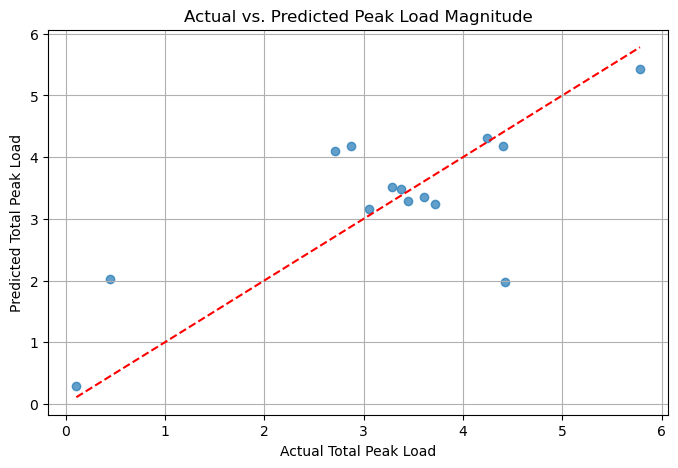

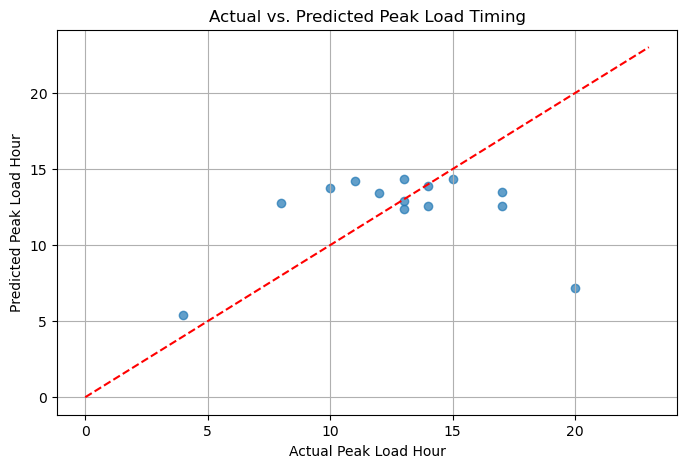

In [87]:

# Plot for Peak Load Magnitude
plt.figure(figsize=(8, 5))
plt.scatter(y_test, preds_magnitude, alpha=0.7)
plt.xlabel("Actual Total Peak Load")
plt.ylabel("Predicted Total Peak Load")
plt.title("Actual vs. Predicted Peak Load Magnitude")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.grid(True)
plt.show()

# Plot for Peak Load Timing
plt.figure(figsize=(8, 5))
plt.scatter(y_test_t, preds_timing, alpha=0.7)
plt.xlabel("Actual Peak Load Hour")
plt.ylabel("Predicted Peak Load Hour")
plt.title("Actual vs. Predicted Peak Load Timing")
plt.plot([0, 23], [0, 23], "r--")
plt.grid(True)
plt.show()
